### Задача оптимизации долей активов в инвестиционном портфеле. 


Пусть есть заданный список активов(тикетов) которые будут входить в портфель, задача состоит в нахождении оптимальных долей для этих активов, таких что риск будет минимальным, а доходность максимальная. Поскольку риск прапорционален доходности - эта задача двумерной оптимизации будет иметь бесконечно много решений, обычно задачу формулируют иначе, например в нашем случае необходимо реализовать:
- Достичь портфеля с минимальной волатильностью.
- Достичь портфеля с максимальной доходностью.
- Для заданного уровня доходности собрать портфель с минимальными рискам.
- Для заданного уровня рисков собрать портфель максимальной доходности.
- Для полученного пространства решений найти решение с максимальным индексом Шарпа.
- Достичь портфеля с максимальной диверсификацией.

Используется статистический подход, исходим априори из следующих предпосылок:
- Каждый актив имеет ожидаемую доходность. Проще всего выразить на основании исторических данных
- Доходность актива тем больше чем больше риск(в широком смысле) инвестиций в него. 
- Цена активов является случайной величиной которая испытывает флуктуации, мера этих флуктуация - стандартное отклонение доходности этого актива $\sigma$, величина отклонения отождествляется с величиной рисков вложений в этот актив. Везде далее риск $\equiv$ величина стандартного отклонения.

Таким образом мы хотим минимизировать стандартное отклонение доходности нашего портфеля и максимизировать взвешанную по весам сумму доходностей активов входящих в портфель.

Рассмотрим математику задачи:

Пусть $r$ - вектор ожидаемых доходностей наших активов. Колличество активов - $n$

Пусть $w$ - вектор долей(весов) активов с которыми они входят в портфель. Все веса положительные, коротки сделки исключим.

Очевидно следующее условие: $\sum_{i=0}^{n} w_i = 1 $ - суммавесов равна 1 = 100%

Тогда ожидаемая доходность портфеля: $\sum_{i=0}^{n} w_i * r_i$

Пусть $V$ - матрица ковариации доходностей активов
Тогда дисперсия доходности портфеля: $\sigma^2 = w^T Vw$

И стандартное отклонение $\sigma = \sqrt{w^T Vw}$

Теперь можно сформулировать задачу:

При следующих условиях:

$\sum_{i=0}^{n} w_i = 1$

$ 0 \leq w_i \leq 1$

Найти решение - веса $w_r$ соответствующие одному из следующих условий:

$w_r = \min (\sigma^2) = \min( w^T Vw )$  -  Это будет решение для минимизации волатильности.

$w_r = \max (\sum_{i=0}^n w_i r_i)$ - Это будет решение для максимизации доходности, палагаю оно будет тривиальное, достаточно взять на 100% в портфель только один самый самый доходный актив

$w_r = \min (\sigma^2) = \min (w^T Vw )$, при условии $\sum_{i=0}^n w_i r_i \geq r_{target}$ где $r_{target}$ - заданная доходность. Это решение для минимизации риска с зарание заданным минимальным уровнем доходности.

$w_r = \max (\sum_{i=0}^n w_i r_i)$, при условии $\sigma^2 = w^T Vw \leq \sigma_{target}^2 $, где $\sigma_{target}^2$ - заданный риск. Это решения для максимизации доходности при заранее заданном уровне риска.

Пусть теперь у нас есть альтернативное вложение с нулевым риском, чья доходность фиксированна и равна $R_f$. Например это облигации развитых стран.

Тогда мы можем посчитать для каждого решения $w$ коэффициент Шарпа. Этот коэффициент показывает насколько выгодно портфель превышает гарантированный доход, по отношению к взятым рискам.

### $S(w) = \frac{E[r - R_f]}{\sigma}$

В пространстве решений задачи, существует единтсвенное решение с максимальным коэффициетом Шарпа:

### $w_r = \max (\frac{(\sum_{i=0}^n w_i r_i) - R_f}{\sqrt{w^T Vw}})$

Решение для наиболее диверсифицированного портфеля может быть полученно при максимизации коэффициента диверсификации:

### $D(w) = \frac{\sum_{i=0}^n w_i \sigma_i}{\sqrt{w^T Vw}}$

### $w_r = \max (\frac{\sum_{i=0}^n w_i \sigma_i}{\sqrt{w^T Vw}})$

где $\sigma_i$ - стандартное отклонение каждого актива.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(precision=3, suppress=True)
sns.set(rc={'figure.figsize':(16,10)})

Теперь напишем функцию которая будет считать все описанные выше решения для произвольного переданного списка активов

In [2]:
def MeanVarianceOptimization(tickets, mystart, myend, rf, rp, sigma_p):
    #tickets - Список тикетов
    #mystart, myend - Время в пределах которого проанализировать активы
    # В формате "YYYY-MM-DD"
    #rf - Процент безрисковой инвестиции в формате "10" для 10% годовых
    #rp - Процент требуемой доходности в формате "10" для 10% годовых
    #sigms_p - Уровень максимальной волатильности
    
    
    Rf = np.log((rf/100 + 1)**(1/250)) # Гарантированная доходность
    Rp = np.log((rp/100 + 1)**(1/250)) # Минимальная доходность
    
    n = len(tickets)
    xinit=np.repeat(1/n, n)
    bnds = tuple([(0,1) for x in xinit])
    
    data = yf.download(tickets, start=mystart, end=myend).Close.pct_change().apply(lambda x: np.log(1+x))
    
    r = data.mean().values
    cov_matx = data.cov().values

    std_div = np.zeros(n)
    for i in range(n):
        std_div[i] = np.sqrt(cov_matx[i,i])
            
            
    def  f_volatility(x, CovarReturns):
        func = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T))
        return func

    def f_returns(x, r_i):
        func = -1 * np.matmul(x.T, r_i)
        return func
    
    def Sharpe_ratio(x, CovarReturns, r_i):
        func = -1 * ((np.matmul(x.T, r_i) - Rf)/np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T)))
        return func
    
    def Diversification_ratio(x, CovarReturns):
        
        func = -1 * (np.matmul(std_div.T, x)/np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T)))
        return func
        
    def sum_is_one(x):
        return x.sum() - 1
    
    def min_returns(x):
        return np.matmul(x.T, r) - Rp
        
    def max_volatility(x):
        return sigma_p - np.sqrt(np.matmul(np.matmul(x, cov_matx), x.T))
        

    cons = ({'type': 'eq', 'fun':sum_is_one},
           {'type': 'ineq', 'fun':min_returns},
           {'type': 'ineq', 'fun':max_volatility})    
    
    res = []
    print('Для следующих тикетов взять соответствующие доли:')
    print(data.columns.values.tolist())
    print()
    res.append(data.columns.values.tolist())
    
    
    
    opt = scipy.optimize.minimize(f_returns, x0 = xinit, args = (r),  bounds = bnds,
                                  constraints = cons[0], tol = 10**-9).x
    print('Для максимального дохода', "%.4f" % ((np.exp(np.matmul(opt, r))-1)*25000),
          'годовых и волатильности', "%.4f" % np.sqrt(np.matmul(np.matmul(opt, cov_matx), opt.T)), ':')
    print(opt)
    print()
    res.append(opt)
    
    
    
    opt = scipy.optimize.minimize(f_volatility, x0 = xinit, args = (cov_matx),
                                  bounds = bnds, constraints = cons[0], tol = 10**-9).x
    print('Для минимальной волатильности', "%.4f" % np.sqrt(np.matmul(np.matmul(opt, cov_matx), opt.T)),
          'и дохода', "%.4f" % ((np.exp(np.matmul(opt, r))-1)*25000), ':')
    print(opt)
    print()
    res.append(opt)
    
    
    
    opt = scipy.optimize.minimize(f_volatility, x0 = xinit, args = (cov_matx),
                                  bounds = bnds, constraints = cons[0:2], tol = 10**-9).x
    print('Для минимальной волатильности при доходе не ниже', rp, '% годовых:')
    print(opt)
    print()
    res.append(opt)
    
    
    
    opt = scipy.optimize.minimize(f_returns, x0 = xinit, args = (r),  bounds = bnds,
                                  constraints = cons[0:3:2], tol = 10**-9).x
    print('Для максимального дохода, при волатильности не выше', sigma_p, ':')
    print(opt)
    print()
    res.append(opt)
    
    
    
    opt = scipy.optimize.minimize(Sharpe_ratio, x0 = xinit, args = ((cov_matx, r)),  bounds = bnds,
                                  constraints = cons[0], tol = 10**-9).x
    print('Портфель с максимальным индексом Шарпа', 
          "%.4f" %((np.matmul(opt, r) - Rf)/np.sqrt(np.matmul(np.matmul(opt, cov_matx), opt.T))))
    print(opt)
    print()
    res.append(opt)
    
    
    
    opt = scipy.optimize.minimize(Diversification_ratio, x0 = xinit, args = (cov_matx),  bounds = bnds,
                                  constraints = cons[0], tol = 10**-9).x
    print('Максимально диверсифицированный портфель')
    print(opt)
    print()
    res.append(opt)
    res.append(np.array([1/n for i in range(n)]))
    return res

Покажем на примере как работает функция, возьмём 10 фондов из разных секторов экономик:

- Energy: XLE
- Materials: XLB
- Industrials: XLI
- Consumer Discretionary: XLY
- Consumer Staples: XLP
- Health Care: XLV
- Financials: XLF
- Information Technology: SMH
- Communication Services: XTL
- Utilities: XLU

In [3]:
tiсkets = ['XLE', 'XLB', 'XLI','XLY', 'XLP', 'XLV', 'XLF', 'SMH', 'XTL', 'XLU']

#listtick = pd.read_csv('tickers.csv')
#listtick.Symbol.values.tolist()

#tiсkets = listtick.Symbol.values[0:20].tolist()


portfolio_columns = ['max return', 'min volatility', 'min vol, target ruturn',
                    'max return, target vol', 'max Sharpe', 'max Diversification', 'Equal shaes']

res = MeanVarianceOptimization(tiсkets, "2016-01-01", "2020-01-01", 4.5, 13, 0.01)

tickets = res[0]
res = res[1:]

pd.DataFrame(np.array(res).T, columns=portfolio_columns, index = tickets)

[*********************100%***********************]  10 of 10 completed
Для следующих тикетов взять соответствующие доли:
['SMH', 'XLB', 'XLE', 'XLF', 'XLI', 'XLP', 'XLU', 'XLV', 'XLY', 'XTL']

Для максимального дохода 24.2688 годовых и волатильности 0.0148 :
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Для минимальной волатильности 0.0063 и дохода 8.6343 :
[0.    0.007 0.024 0.113 0.    0.265 0.377 0.128 0.077 0.009]

Для минимальной волатильности при доходе не ниже 13 % годовых:
[0.126 0.    0.    0.165 0.    0.    0.539 0.035 0.135 0.   ]

Для максимального дохода, при волатильности не выше 0.01 :
[0.626 0.    0.    0.    0.    0.    0.374 0.    0.    0.   ]

Портфель с максимальным индексом Шарпа 0.0582
[0.564 0.    0.    0.    0.    0.    0.436 0.    0.    0.   ]

Максимально диверсифицированный портфель
[0.122 0.    0.143 0.17  0.    0.    0.493 0.024 0.    0.048]



,max return,min volatility,"min vol, target ruturn","max return, target vol",max Sharpe,max Diversification,Equal shaes
SMH,1.0000,0.0000,0.1264,0.6255,0.5642,0.1219,0.1000
XLB,0.0000,0.0073,0.0000,0.0000,0.0000,0.0000,0.1000
XLE,0.0000,0.0235,0.0000,0.0000,0.0000,0.1426,0.1000
XLF,0.0000,0.1133,0.1653,0.0000,0.0000,0.1703,0.1000
XLI,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1000
XLP,0.0000,0.2655,0.0000,0.0000,0.0000,0.0000,0.1000
XLU,0.0000,0.3770,0.5386,0.3745,0.4358,0.4932,0.1000
XLV,0.0000,0.1277,0.0347,0.0000,0.0000,0.0243,0.1000
XLY,0.0000,0.0773,0.1350,0.0000,0.0000,0.0000,0.1000
XTL,0.0000,0.0085,0.0000,0.0000,0.0000,0.0477,0.1000


Теперь можем посмотреть ежедневные доходности этих фондов и гафики их роста:

In [14]:
start = "2020-01-02"
end = "2022-03-10"

data = yf.download(tiсkets, start, end).Close

data_chg = data.pct_change().apply(lambda x: np.log(1+x))

r = data_chg.mean() #Ежедневные доходности
#условно каждый день цены активов умножаются на "е" в степени этих чисел
np.exp(r)


[*********************100%***********************]  10 of 10 completed


SMH   1.0010
XLB   1.0006
XLE   1.0004
XLF   1.0003
XLI   1.0003
XLP   1.0003
XLU   1.0002
XLV   1.0004
XLY   1.0005
XTL   1.0004
dtype: float64

<AxesSubplot:xlabel='Date'>

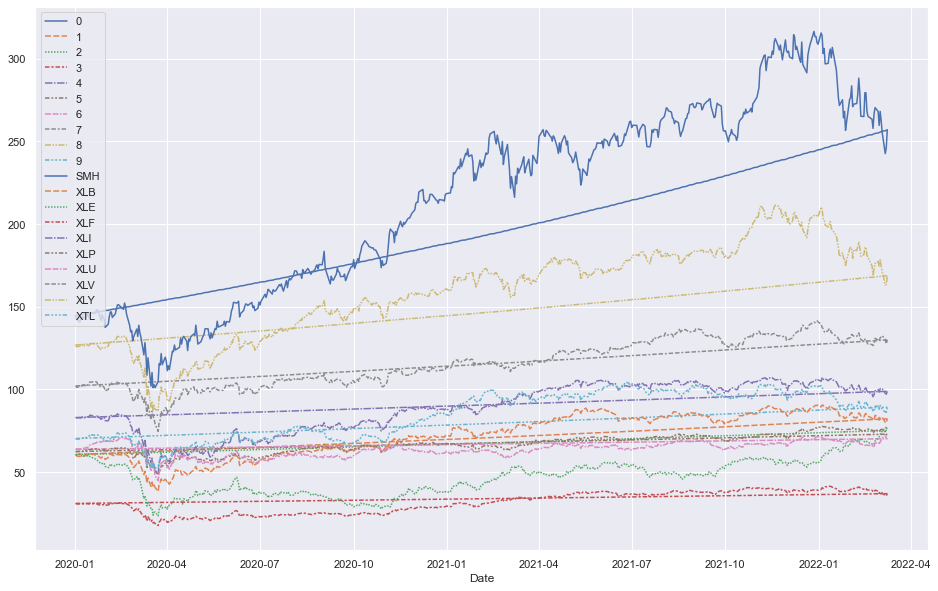

In [15]:
ideal_r = np.ones(data.shape)
ideal_r[0] = data.iloc[0:1, :].values
for i in range(data.shape[0]-1):
    for j in range(data.shape[1]):
        ideal_r[i+1, j] = ideal_r[i, j]*np.exp(r[j])


sns.lineplot(data = pd.DataFrame(ideal_r, index=data.index))
sns.lineplot(data = data)

Теперь посмотрим как в истории росли портфели с найдеными оптимальными составами

[*********************100%***********************]  10 of 10 completed


<AxesSubplot:xlabel='Date'>

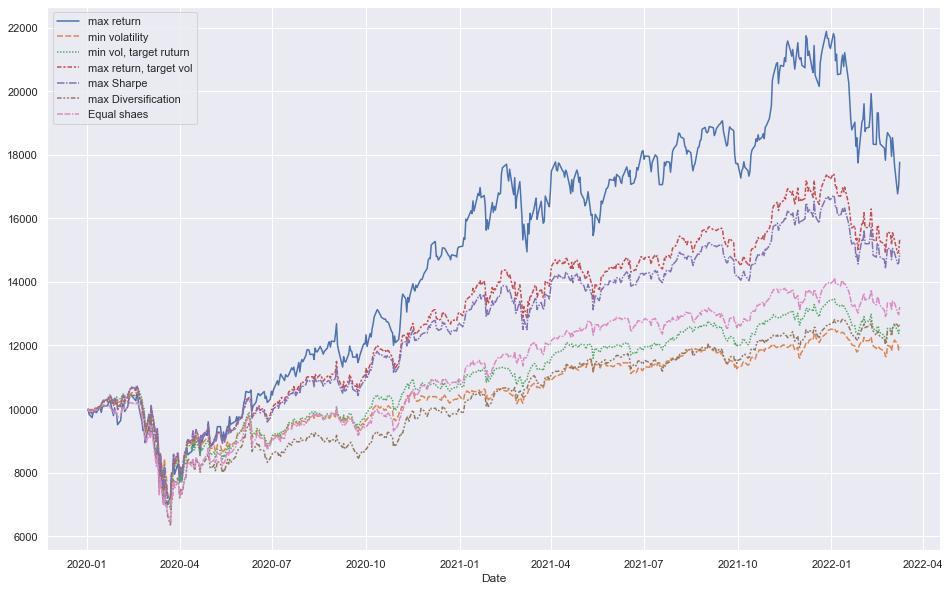

In [16]:
data = yf.download(tiсkets, start, end).Close
data_chg = data.pct_change()

dep = 10000
data_chg = data.pct_change()

best_portfolio = [[dep] for i in range(7)]

for i in range(7):
    for j in range(data_chg.shape[0]-1):
        k = (np.matmul(res[i]*best_portfolio[i][j], (data_chg.iloc[j+1:j+2,:].values + 1).T).tolist()[0])
        best_portfolio[i].append(k)
        
best_portfolio = pd.DataFrame(np.array(best_portfolio).T, index = data.index, columns=portfolio_columns)

sns.lineplot(data = best_portfolio)

Материалы и источники:
- https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook
- https://pyportfolioopt.readthedocs.io/en/stable/MeanVariance.html
- https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/2-Mean-Variance-Optimisation.ipynb
- https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- https://www.tobam.fr/wp-content/uploads/2014/12/TOBAM-JoPM-Maximum-Div-2008.pdf
- https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D0%9C%D0%B0%D1%80%D0%BA%D0%BE%D0%B2%D0%B8%D1%86%D0%B0#%D0%9F%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8C_%D0%A2%D0%BE%D0%B1%D0%B8%D0%BD%D0%B0_%D0%BC%D0%B8%D0%BD%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B8%D1%81%D0%BA%D0%B0